In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
from tqdm.auto import tqdm
from time_series import create_time_series
sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))
import fsrs_optimizer
import plotly.express as px
import numpy as np

tqdm.pandas()

In [69]:
# Median: 8798
# Most: 6810

df = pd.read_parquet(
    "../anki-revlogs-10k/revlogs", filters=[("user_id", "=", 9182)] 
)
df.size

397928

In [70]:
df.drop(df[~df["rating"].isin([1, 2, 3, 4])].index, inplace=True)

In [71]:
df

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id
10,10,0,4,0,4480,-1,-1,9182
12,11,0,3,0,16896,-1,-1,9182
14,12,0,2,0,24913,-1,-1,9182
16,13,0,3,0,22897,-1,-1,9182
18,14,0,1,0,31731,-1,-1,9182
...,...,...,...,...,...,...,...,...
49740,7241,870,2,1,332,1,53155,9182
49124,7113,870,2,2,278,5,435448,9182
49726,7238,870,2,1,330,1,53151,9182
46075,6581,870,2,2,332,34,2937342,9182


In [72]:
df[df["card_id"] == 230]

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id
792,230,106,4,0,2253,-1,-1,9182


In [73]:
df["prior_reviews"] = df.groupby("day_offset").cumcount()

In [74]:
print("creating time series")
df: pd.DataFrame = create_time_series(df)
print("training")
trainer = fsrs_optimizer.Trainer(df, df, fsrs_optimizer.DEFAULT_PARAMETER)
w = trainer.train()

creating time series
training


train:   0%|          | 0/30985 [00:00<?, ?it/s]

iteration: 3072
w: [0.4897, 1.2826, 3.2755, 15.758, 7.0966, 0.6434, 1.3902, 0.0836, 1.6478, 0.0207, 1.1209, 2.0186, 0.0317, 0.3746, 2.349, 0.3169, 3.0924, 0.5832, 0.7682]
iteration: 6144
w: [0.5191, 1.3279, 3.3431, 15.7836, 7.0334, 0.7223, 1.358, 0.1264, 1.7241, 0.0, 1.1948, 2.0088, 0.0271, 0.364, 2.3558, 0.3604, 3.1712, 0.6469, 0.8274]
iteration: 9216
w: [0.5255, 1.3522, 3.3977, 15.8119, 6.9992, 0.7697, 1.3464, 0.1472, 1.7759, 0.0, 1.2427, 1.9823, 0.0488, 0.335, 2.35, 0.3736, 3.2284, 0.6881, 0.8618]
iteration: 12288
w: [0.5279, 1.3663, 3.4356, 15.8243, 6.9908, 0.7812, 1.3493, 0.15, 1.7988, 0.0, 1.2631, 1.9668, 0.0597, 0.3161, 2.3473, 0.3554, 3.2596, 0.7048, 0.8775]
iteration: 15360
w: [0.5147, 1.3715, 3.4774, 15.8209, 6.9872, 0.7858, 1.3493, 0.1506, 1.8113, 0.0, 1.274, 1.961, 0.0602, 0.3086, 2.3466, 0.3404, 3.285, 0.7249, 0.8964]
iteration: 18432
w: [0.5187, 1.3916, 3.4933, 15.8257, 6.9873, 0.7793, 1.3572, 0.1469, 1.819, 0.0, 1.2805, 1.951, 0.0638, 0.2973, 2.3374, 0.3343, 3.2963, 0.74

In [75]:
import math

DECAY = -0.5
FACTOR = 0.9 ** (1 / DECAY) - 1

def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

def stability_after_success(s, r, d, rating):
    hard_penalty = w[15] if rating == 2 else 1
    easy_bonus = w[16] if rating == 4 else 1
    return max(
        0.01,
        s * (
            1
            + math.exp(w[8])
            * (11 - d)
            * (s ** -w[9])
            * (math.exp((1 - r) * w[10]) - 1)
            * hard_penalty
            * easy_bonus
        )
    )

def stability_after_failure(s, r, d):
    return max(
        0.01,
        min(
            w[11]
            * (d ** -w[12])
            * ((s + 1) ** w[13] - 1)
            * math.exp((1 - r) * w[14]),
            s / math.exp(w[17] * w[18])
        )
    )

def stability_short_term(s, init_rating=None):
    if init_rating is not None:
        rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[init_rating - 1]
        session_len = fsrs_optimizer.DEFAULT_FIRST_SESSION_LENS[init_rating - 1]
    else:
        rating_offset = fsrs_optimizer.DEFAULT_FORGET_RATING_OFFSET
        session_len = fsrs_optimizer.DEFAULT_FORGET_SESSION_LEN
    
    new_s = s * math.exp(
        w[17] * (rating_offset + session_len * w[18])
    )
    return new_s

def init_d(rating):
    return w[4] - math.exp(w[5] * (rating - 1)) + 1

def init_d_with_short_term(rating):
    rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[rating - 1]
    new_d = init_d(rating) - w[6] * rating_offset
    return max(1, min(new_d, 10))

def linear_damping(delta_d, old_d):
    return delta_d * (10 - old_d) / 9

def mean_reversion(target, value, alpha=0.5):
    return alpha * target + (1 - alpha) * value

def next_d(d, rating):
    delta_d = -w[6] * (rating - 3)
    new_d = d + linear_damping(delta_d, d)
    new_d = mean_reversion(init_d(4), new_d)
    return max(1, min(new_d, 10))


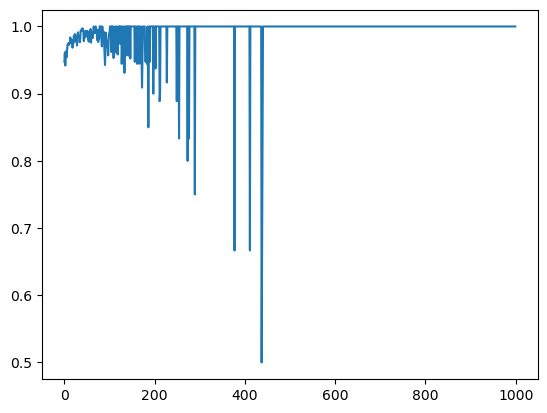

In [76]:
mean = df.groupby("prior_reviews")["y"].mean()
plt.plot(mean)
plt.show()

In [77]:
def memory_state(df):
    t_history = [int(t) for t in df["t_history"].split(",")]
    r_history = [int(r) for r in df["r_history"].split(",")]
    difficulty = None
    stability = None
    retrievability = None
    for delta_t, rating in zip(t_history, r_history):
        if stability is None:  # New card
            difficulty = init_d_with_short_term(rating)
            stability = stability_short_term(w[rating - 1], init_rating=rating)
        else:
            retrievability = power_forgetting_curve(delta_t, stability)
            if rating > 1:
                stability = stability_after_success(
                    stability, retrievability, difficulty, rating
                )
            else:
                stability = stability_after_failure(stability, retrievability, difficulty)
            difficulty = next_d(difficulty, rating)

    return stability, difficulty, retrievability


df["s"], df["d"], df["r"] = zip(*df.progress_apply(memory_state, axis=1))

  0%|          | 0/30985 [00:00<?, ?it/s]

In [78]:
df["loss"] = df.apply(lambda df: (df["y"] - df["r"]) ** 2, axis=1)

<Figure size 640x480 with 0 Axes>

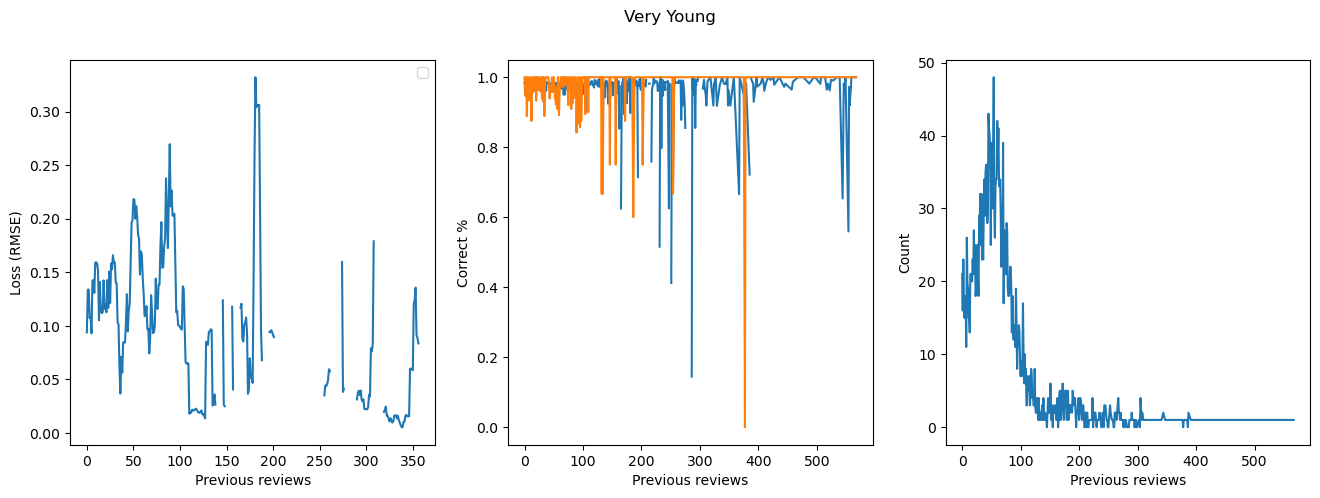

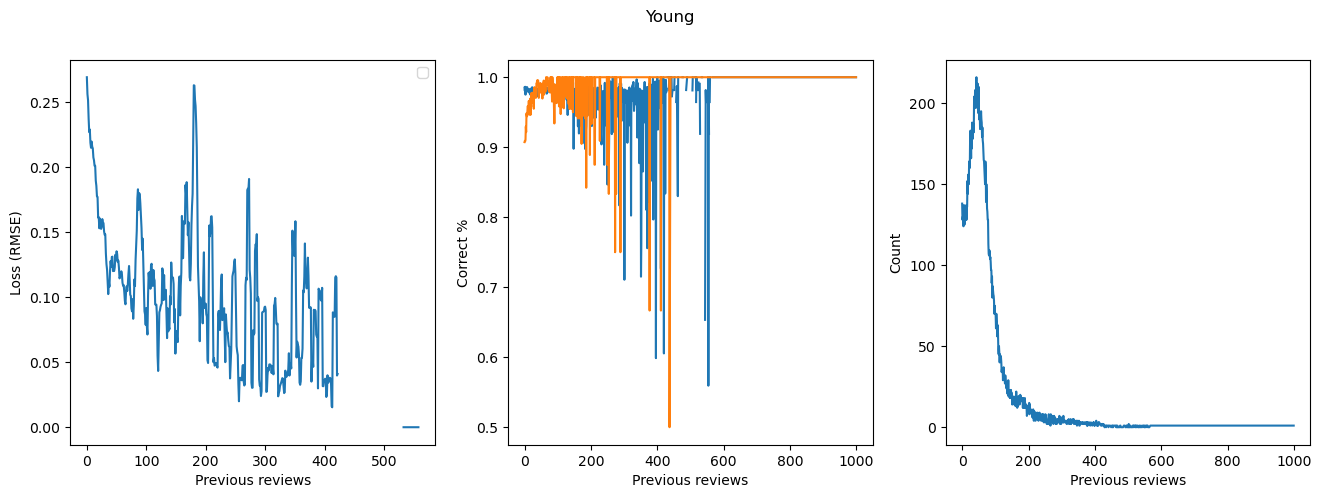

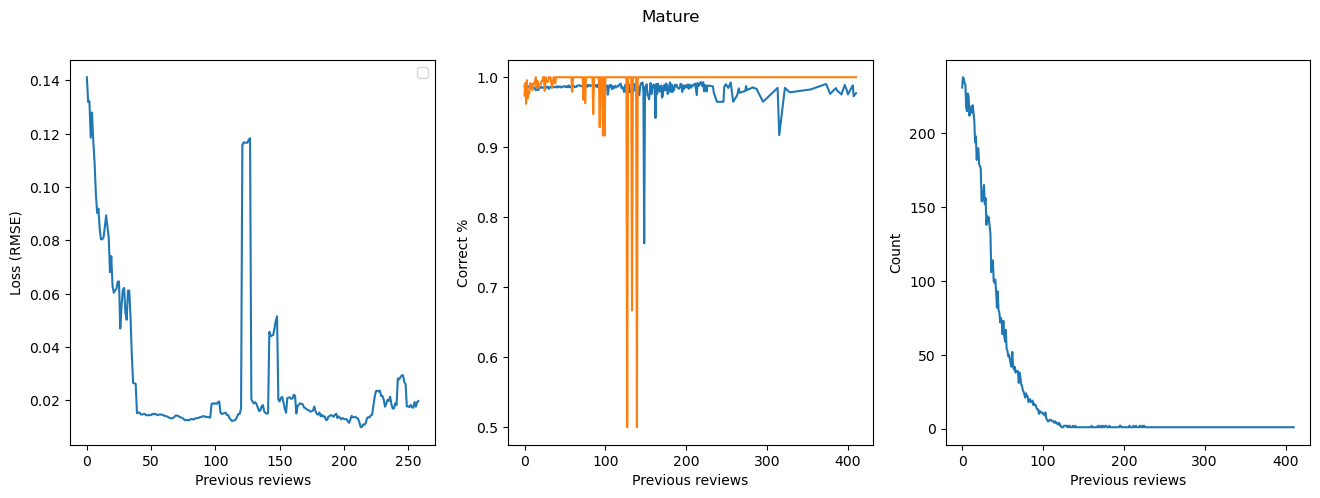

In [79]:
plt.clf()
categories = [
    #("Learn", -1, 1), 
    ("Very Young", 4, 8), 
    ("Young", -1, 21), 
    ("Mature", 21, 1e20)
]

# https://stackoverflow.com/a/54628145/24162642
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


for name, lower, upper in categories:
    df_filtered = df[(df["elapsed_days"] > lower) & (df["elapsed_days"] <= upper)].groupby("prior_reviews")
    loss = df_filtered["loss"].mean() ** 0.5
    loss = moving_average(loss, 7)

    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(name)
    ax1 = fig.add_subplot(131)

    ax1.set_xlabel('Previous reviews')
    ax1.set_ylabel('Loss (RMSE)')
    ax1.plot(loss)
    ax1.legend()

    ax2 = fig.add_subplot(132)

    ax2.plot(df_filtered["r"].mean())
    ax2.plot(df_filtered["y"].mean())
    ax2.set_xlabel('Previous reviews')
    ax2.set_ylabel('Correct %')

    ax3 = fig.add_subplot(133)

    ax3.plot(df_filtered["r"].count())
    ax3.set_xlabel('Previous reviews')
    ax3.set_ylabel('Count') # Number of days that the user had that many reviews or more

    plt.show()


In [80]:
fig = px.scatter_3d(df[(df["elapsed_days"] < 21) & (df["elapsed_days"] > 0)], x="prior_reviews", y="s", z="loss", range_y=(0, 21))
with open("out.html", "w") as f:
    f.write(fig.to_html())